In [1]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import dask.dataframe as ddf
import joblib
import dask.distributed
from distributed import Client, LocalCluster
from pymongo import MongoClient
import pandas as pd
import time
from dask_ml.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from dask_ml.model_selection import train_test_split
from sklearn.utils import shuffle
import dask.bag as daskb
import numpy as np
from dask_ml.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, classification_report

In [2]:
# Database
client = MongoClient("localhost:27017")

# Collection name
db = client["hotel-reviews-database"]

In [3]:
resultMongo = db.clean_reviews.find()
source = list(resultMongo)
resultDf = pd.DataFrame(source)

# Reindex dataframe
resultDf = shuffle(resultDf)
resultDf.reset_index(drop=True)
print(resultDf.isnull())
resultDf.info()

# Transform dataframe into a dask dataframe/ delete id row
dfDask = ddf.from_pandas(resultDf, npartitions=4)
dfDask = dfDask.drop('_id', axis=1)

          _id  Hotel_Name  Reviewer_Score  Review  label
105810  False       False           False   False  False
7350    False       False           False   False  False
112881  False       False           False   False  False
79581   False       False           False   False  False
64606   False       False           False   False  False
...       ...         ...             ...     ...    ...
65585   False       False           False   False  False
27891   False       False           False   False  False
2573    False       False           False   False  False
16338   False       False           False   False  False
114272  False       False           False   False  False

[121757 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 121757 entries, 105810 to 114272
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   _id             121757 non-null  object 
 1   Hotel_Name      121757 non-null

In [4]:
# n_workers = threadpools
c = Client(processes=False, threads_per_worker=4, n_workers=2, memory_limit='32GB')
c

Client Scheduler: inproc://192.168.178.38/119912/1 Dashboard: http://192.168.178.38:8787/status,Cluster Workers: 2 Cores: 8 Memory: 16.90 GB


In [5]:
# split dataset in features and target variable, X is hoofdletter
X = dfDask['Review'].values
y = dfDask['label'].values

In [6]:
X = X.compute()
y = y.compute()

In [7]:
print(type(X))

<class 'numpy.ndarray'>


In [8]:
# Split data in train set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [9]:
X_train = daskb.from_sequence(X_train, npartitions=2)
X_test = daskb.from_sequence(X_test, npartitions=2)

In [10]:
cv = CountVectorizer(max_features=1000, ngram_range=(1,2))

In [11]:
X_cv_train = cv.fit(X_train)
X_cv_test = cv.fit(X_test)

X_cv_train = cv.transform(X_train)
X_cv_test = cv.transform(X_test)

In [12]:
X_final_train = X_cv_train.compute()
X_final_test = X_cv_test.compute()

In [13]:
print(X_final_train.shape)
print(X_final_test.shape)

(97405, 1085)
(24352, 1085)


In [14]:
logisticRegression = LogisticRegression(fit_intercept=False, solver_kwargs={"normalize": False})

In [15]:
%%time
# Fit
with joblib.parallel_backend("dask"):
    logModel = logisticRegression.fit(X_final_train.toarray(), y_train)

Wall time: 33min 3s


In [16]:
%%time
# Predict
logPredict = logModel.predict(X_final_test.toarray())

Wall time: 171 ms


In [17]:
print("Accuracy score: ", accuracy_score(y_test, logPredict))

Accuracy score:  0.9296977660972404


In [18]:
aucJamal = roc_auc_score(y_test, logPredict)
print(aucJamal)

0.9293602763405542


In [19]:
from sklearn import metrics

accuracy = metrics.accuracy_score(y_test, logPredict)
recall = metrics.recall_score(y_test, logPredict)
precision = metrics.precision_score(y_test, logPredict)
f1_score = 2 * (precision * recall) / (precision + recall)

cm = metrics.confusion_matrix(y_test, logPredict)

print(f"Accuracy: {accuracy} | Precision: {precision} | Recall: {recall}")
print(f"F1 score: {f1_score}")

Accuracy: 0.9296977660972404 | Precision: 0.9409226190476191 | Recall: 0.9323208493069891
F1 score: 0.9366019848911273


In [20]:
print(cm)

[[ 9994   794]
 [  918 12646]]


In [21]:
fpr, tpr, _ = roc_curve(y_test, logPredict)
aucScore = auc(fpr, tpr)

print(aucScore)

0.9293602763405542


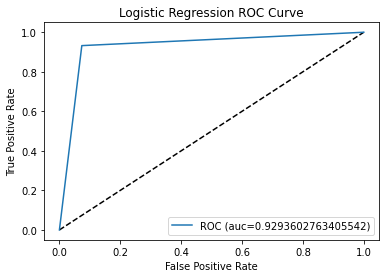

In [22]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (auc=' + str(aucScore) + ')')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.show()

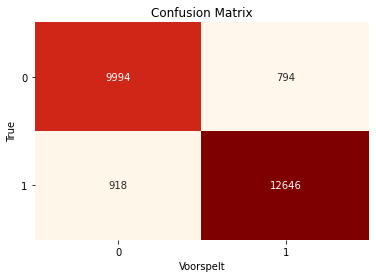

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = [0, 1]
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.OrRd, cbar=False)
ax.set(xlabel="Voorspelt",
ylabel="True",
xticklabels=classes,
yticklabels=classes,
title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()